# Language Identifier

## Download Data

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d basilb2s/language-detection

100% 542k/542k [00:00<00:00, 733kB/s]
100% 542k/542k [00:00<00:00, 733kB/s]


In [ ]:
!unzip language-detection.zip

Archive:  language-detection.zip
  inflating: Language Detection.csv  


## Import Packages

In [20]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sys.path.append(os.path.realpath('..'))
from src import Explorer, Cleaner, Visualizer, LSTM_model, GRU_model, CONV_model, GridSearch, Graphs

## Explore Data

In [34]:
data = pd.read_csv("/home/hossamasaad/Desktop/Workspace/Langauge Identifier/Language-Identifier/data/raw/Language Detection.csv")

In [ ]:
data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [ ]:
data.tail()

,Text,Language
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada
10336,ಟೆರ್ರಿ ನೀವು ನಿಜವಾಗಿಯೂ ಆ ದೇವದೂತನಂತೆ ಸ್ವಲ್ಪ ಕಾಣು...,Kannada


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [ ]:
data.shape

(10337, 2)

Check duplicated values

In [35]:
len(data[data.duplicated() == True])

66

There are 66 duplicate rows, let's drop them...

In [36]:
data.drop(data[data.duplicated()].index, axis=0, inplace=True)

In [37]:
data.shape

(10271, 2)

Let's check the number of sentences for each langauge

In [38]:
pd.DataFrame(data['Language'].value_counts())

,Language
English,1382
French,1007
Spanish,816
Portugeese,736
Italian,694
Russian,688
Sweedish,673
Malayalam,591
Dutch,542
Arabic,532


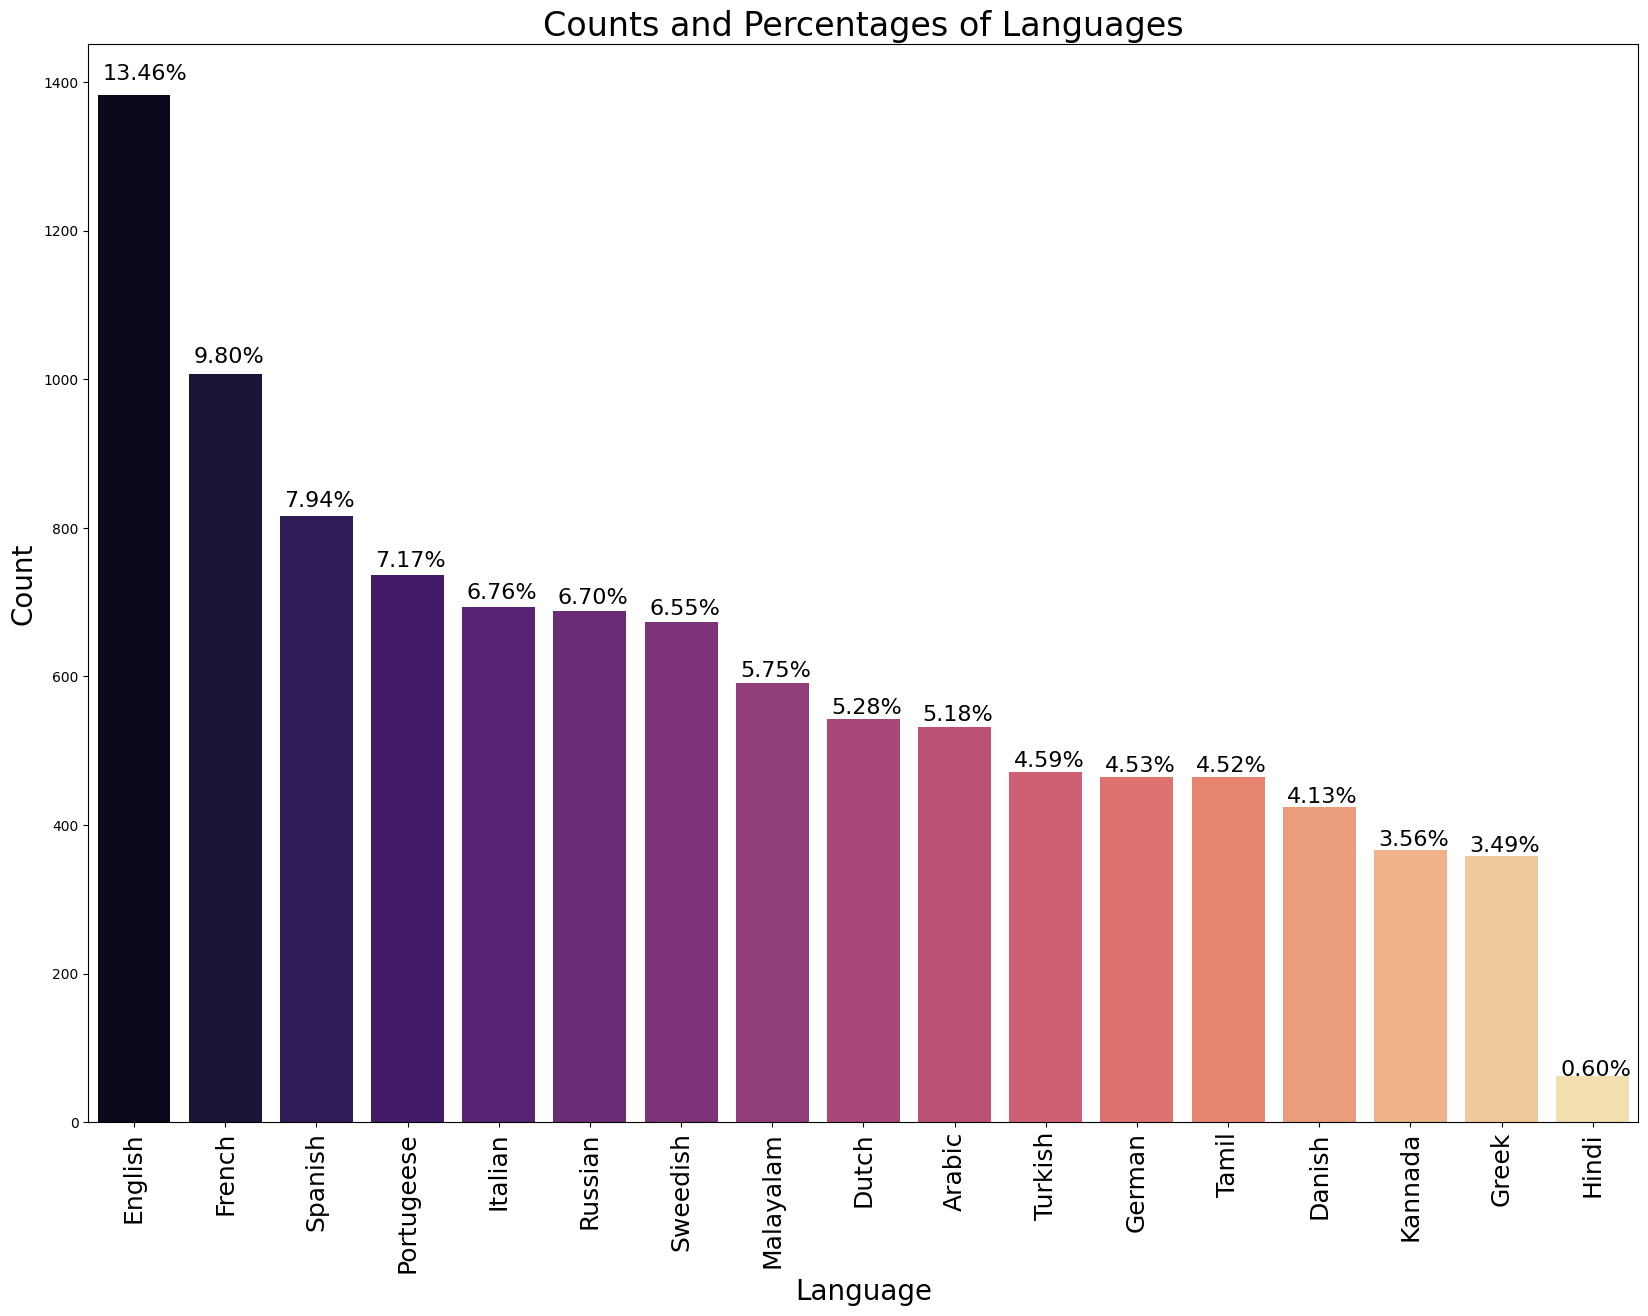

In [ ]:
visualizer = Visualizer(data)
visualizer.show_langauges_counts()

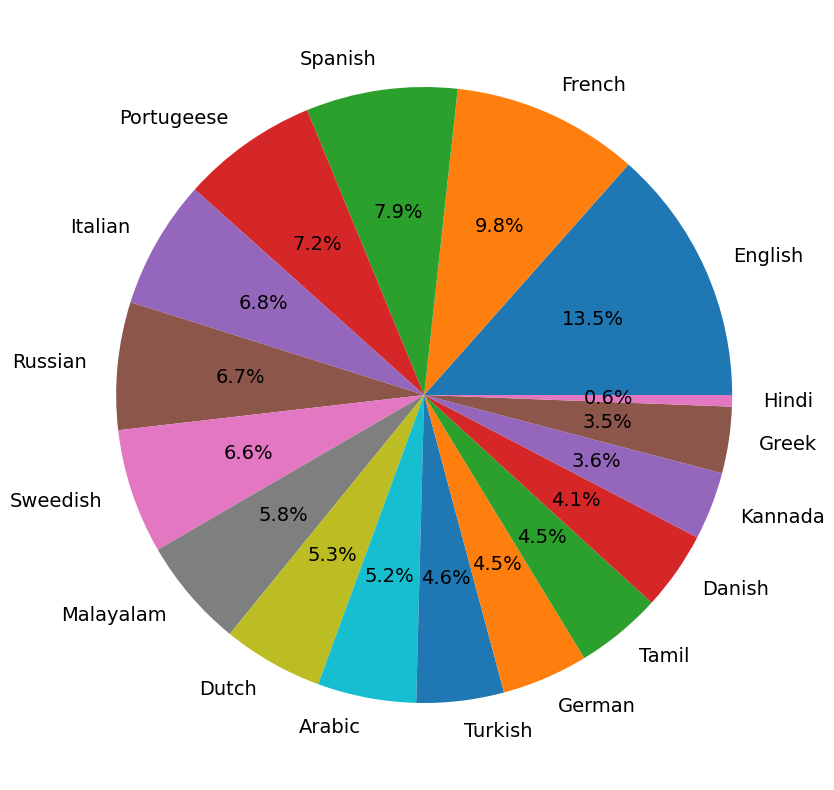

In [ ]:
visualizer.show_percentage()

There is no enough data in `Hindi` langauge so we will drop this language

In [39]:
data = data[ data['Language'] != 'Hindi']

Now let's check again

In [40]:
pd.DataFrame(data['Language'].value_counts())

,Language
English,1382
French,1007
Spanish,816
Portugeese,736
Italian,694
Russian,688
Sweedish,673
Malayalam,591
Dutch,542
Arabic,532


In [43]:
# create explorer
explorer = Explorer(data)

In [ ]:
explorer.show_sentences(10)

Text: Trained models derived from biased data can result in skewed or undesired predictions.
Langauge: English
--------------------------------------------------------------------------------
Text: أنت تحب الجلوس ، يمكنك القول أنني لا أستطيع أن أهتم كثيرًا ، فهذا ممل جدًا.
Langauge: Arabic
--------------------------------------------------------------------------------
Text: i can't thank you enough.
Langauge: English
--------------------------------------------------------------------------------
Text: Estar aturdido tan estupendo se usa para describir algo que es increíblemente bueno, por ejemplo, se ve estupenda con ese vestido o qué vista tan estupenda desde este balcón o estoy leyendo este libro estupendo que no puedo dejar de escribir qué tal si vas y contar.
Langauge: Spanish
--------------------------------------------------------------------------------
Text: evitando una domanda.
Langauge: Italian
-------------------------------------------------------------------------------

Let's get the longest sentense

In [44]:
explorer.get_longest_length()

309

The sentences contain some single letters and numbers so we need to clear these sentences

In [45]:
# Get sentences and labels
sentences, labels = explorer.get_sentences_and_labels()

In [46]:
# Create cleaner
cleaner = Cleaner()

In [47]:
cleared_sentence = cleaner.clear_sentences(sentences)

/home/hossamasaad/Desktop/Workspace/Langauge Identifier/Language-Identifier/src/data/cleaner.py:20: FutureWarning: Possible nested set at position 1
  sentence = re.sub(r'[[]]', ' ', sentence)


In [48]:
cleared_data = pd.DataFrame({"Text": cleared_sentence,
                             "Language": labels})

Now let's explore the cleared data

In [49]:
explorer2 = Explorer(cleared_data)

In [ ]:
explorer2.show_sentences(10)

Text: wikipress[ ha messo in vendita un libro in brossura dell'edizione comprensivo di un dvd
Langauge: Italian
--------------------------------------------------------------------------------
Text: i've lost my phone and i'm in fix or our bus broke down this morning and i'm in fix my friend always turns to me for help when he's in fix and when the going is good he forgets about
Langauge: English
--------------------------------------------------------------------------------
Text: nature dækker en lang række forskningsgrene hvor vigtige nye opdagelser og original forskning bliver udgivet enten som artikler eller som letters tidsskriftet
Langauge: Danish
--------------------------------------------------------------------------------
Text: finalmente wikipédia não deve tomar partido
Langauge: Portugeese
--------------------------------------------------------------------------------
Text: يستخدم هذا البرنامج في ويكيبيديا ومشاريع ويكيميديا الأخرى بالإضافة إلى العديد من مواقع الويكي
Lang

In [50]:
max_len = explorer2.get_longest_length()
max_len

219

In [ ]:
visualizer2 = Visualizer(cleared_data)

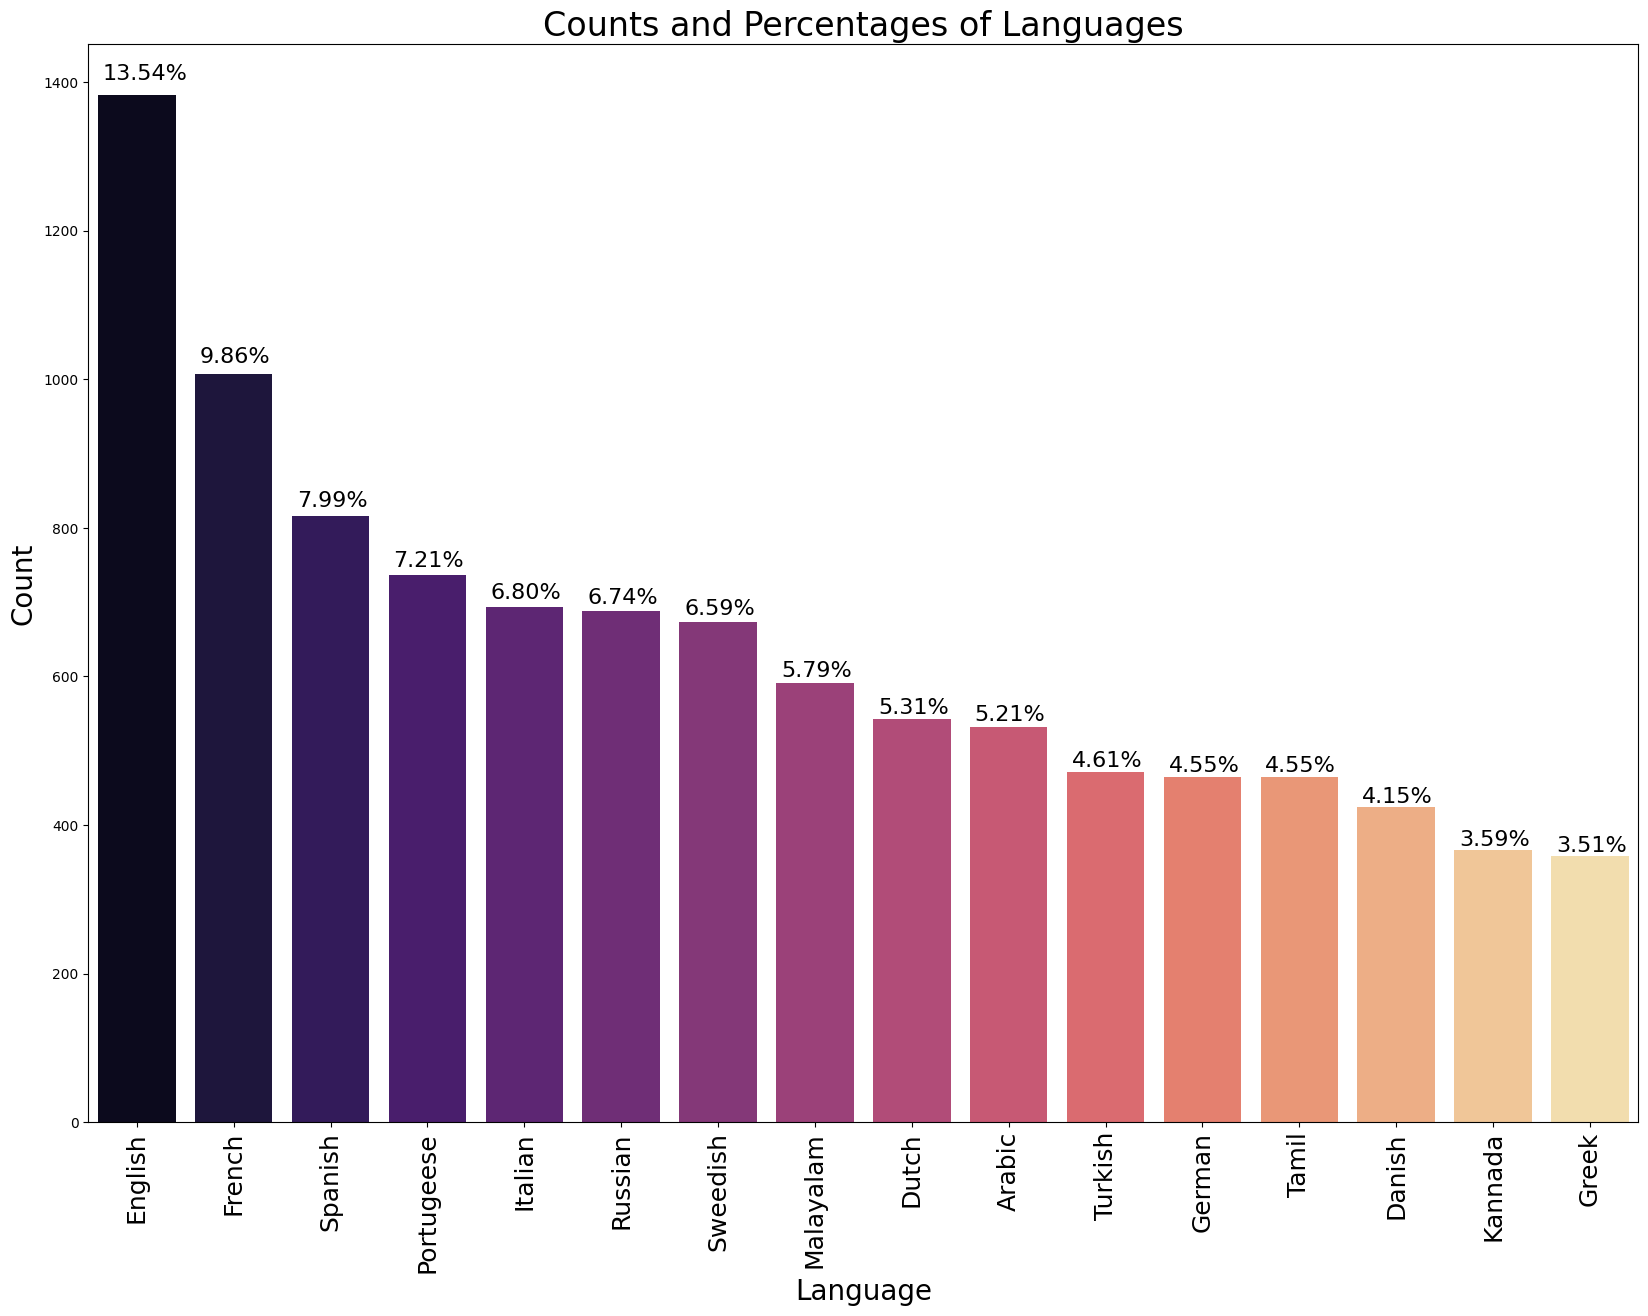

In [ ]:
visualizer2.show_langauges_counts(save_fig=True)

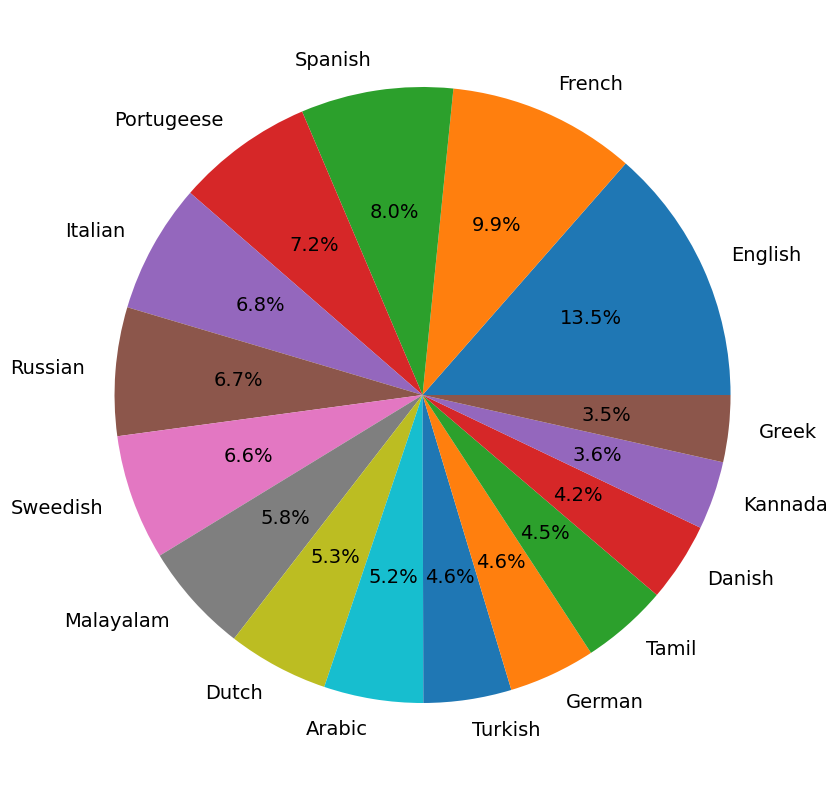

In [ ]:
visualizer2.show_percentage(save_fig=True)

## Modeling

### Encode labels

In [51]:
label_encoder = LabelEncoder()
encoded_labels = to_categorical(label_encoder.fit_transform(labels))

### Split data

In [52]:
train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(cleared_sentence,
                                                                                encoded_labels,
                                                                                test_size = 0.20,
                                                                                random_state = 42)

### Tokenizing

In [53]:
# Create a tokenizer
tokenizer = Tokenizer()

# Fit texts
tokenizer.fit_on_texts(train_sentences)

# word index
word_index = tokenizer.word_index

# total words
total_words = len(word_index) + 1

# convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)

# padded sequences
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating='post')  

### Save Data

In [ ]:
joblib.dump(labels,       'Language-Identifier/data/processed/labels.pkl'      )
joblib.dump(train_padded, 'Language-Identifier/data/processed/train_padded.pkl')
joblib.dump(train_labels, 'Language-Identifier/data/processed/train_labels.pkl')
joblib.dump(valid_padded, 'Language-Identifier/data/processed/valid_padded.pkl')
joblib.dump(valid_labels, 'Language-Identifier/data/processed/valid_labels.pkl')

### Load Data

In [ ]:
max_len     = 219
total_words = 38679
labels       = joblib.load('/Language-Identifier/data/processed/labels.pkl'      )
train_padded = joblib.load('/Language-Identifier/data/processed/train_padded.pkl')
train_labels = joblib.load('/Language-Identifier/data/processed/train_labels.pkl')
valid_padded = joblib.load('/Language-Identifier/data/processed/valid_padded.pkl')
valid_labels = joblib.load('/Language-Identifier/data/processed/valid_labels.pkl')

### Training

#### Define a grid of the hyperparameter search space

In [3]:
# define a grid of the hyperparameter search space

grid = dict(
	units   = [128, 64, 32],
    emb_dim = [128, 256, 512],
    dropout = [0.3, 0.4, 0.5]
)

#### LSTM Model 

In [ ]:
model = LSTM_model

In [ ]:
search = GridSearch(model, grid, total_words, max_len)

In [ ]:
search.fit(train_padded, train_labels, valid_padded, valid_labels, 10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 219, 128)          4950912   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
Total params: 5,222,832
Trainable params: 5,222,832
Non-trainable params: 0
____________________________________________

#####  Save model

In [3]:
best_model = search.get_best()
joblib.dump(best_model, 'best_lstm.pkl')
joblib.dump(best_model.history, 'lstm_history.pkl')

['lstm_history.pkl']

##### Load model

In [5]:
model = joblib.load('/home/hossamasaad/Desktop/Workspace/Langauge Identifier/Language-Identifier/models/best_lstm.pkl')
history = joblib.load('/home/hossamasaad/Desktop/Workspace/Langauge Identifier/Language-Identifier/models/lstm_history.pkl')

##### Visualize model

In [7]:
lstm_graph = Graphs(model, history)

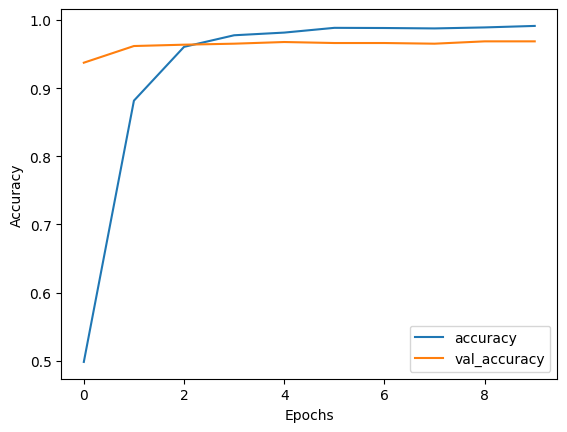

In [9]:
lstm_graph.accuracy(save_fig='lstm_accuracy')

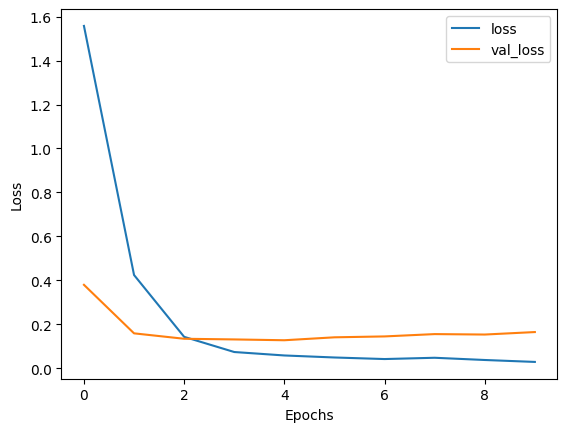

In [10]:
lstm_graph.loss(save_fig='lstm_loss')

64/64 [==============================] - 30s 397ms/step


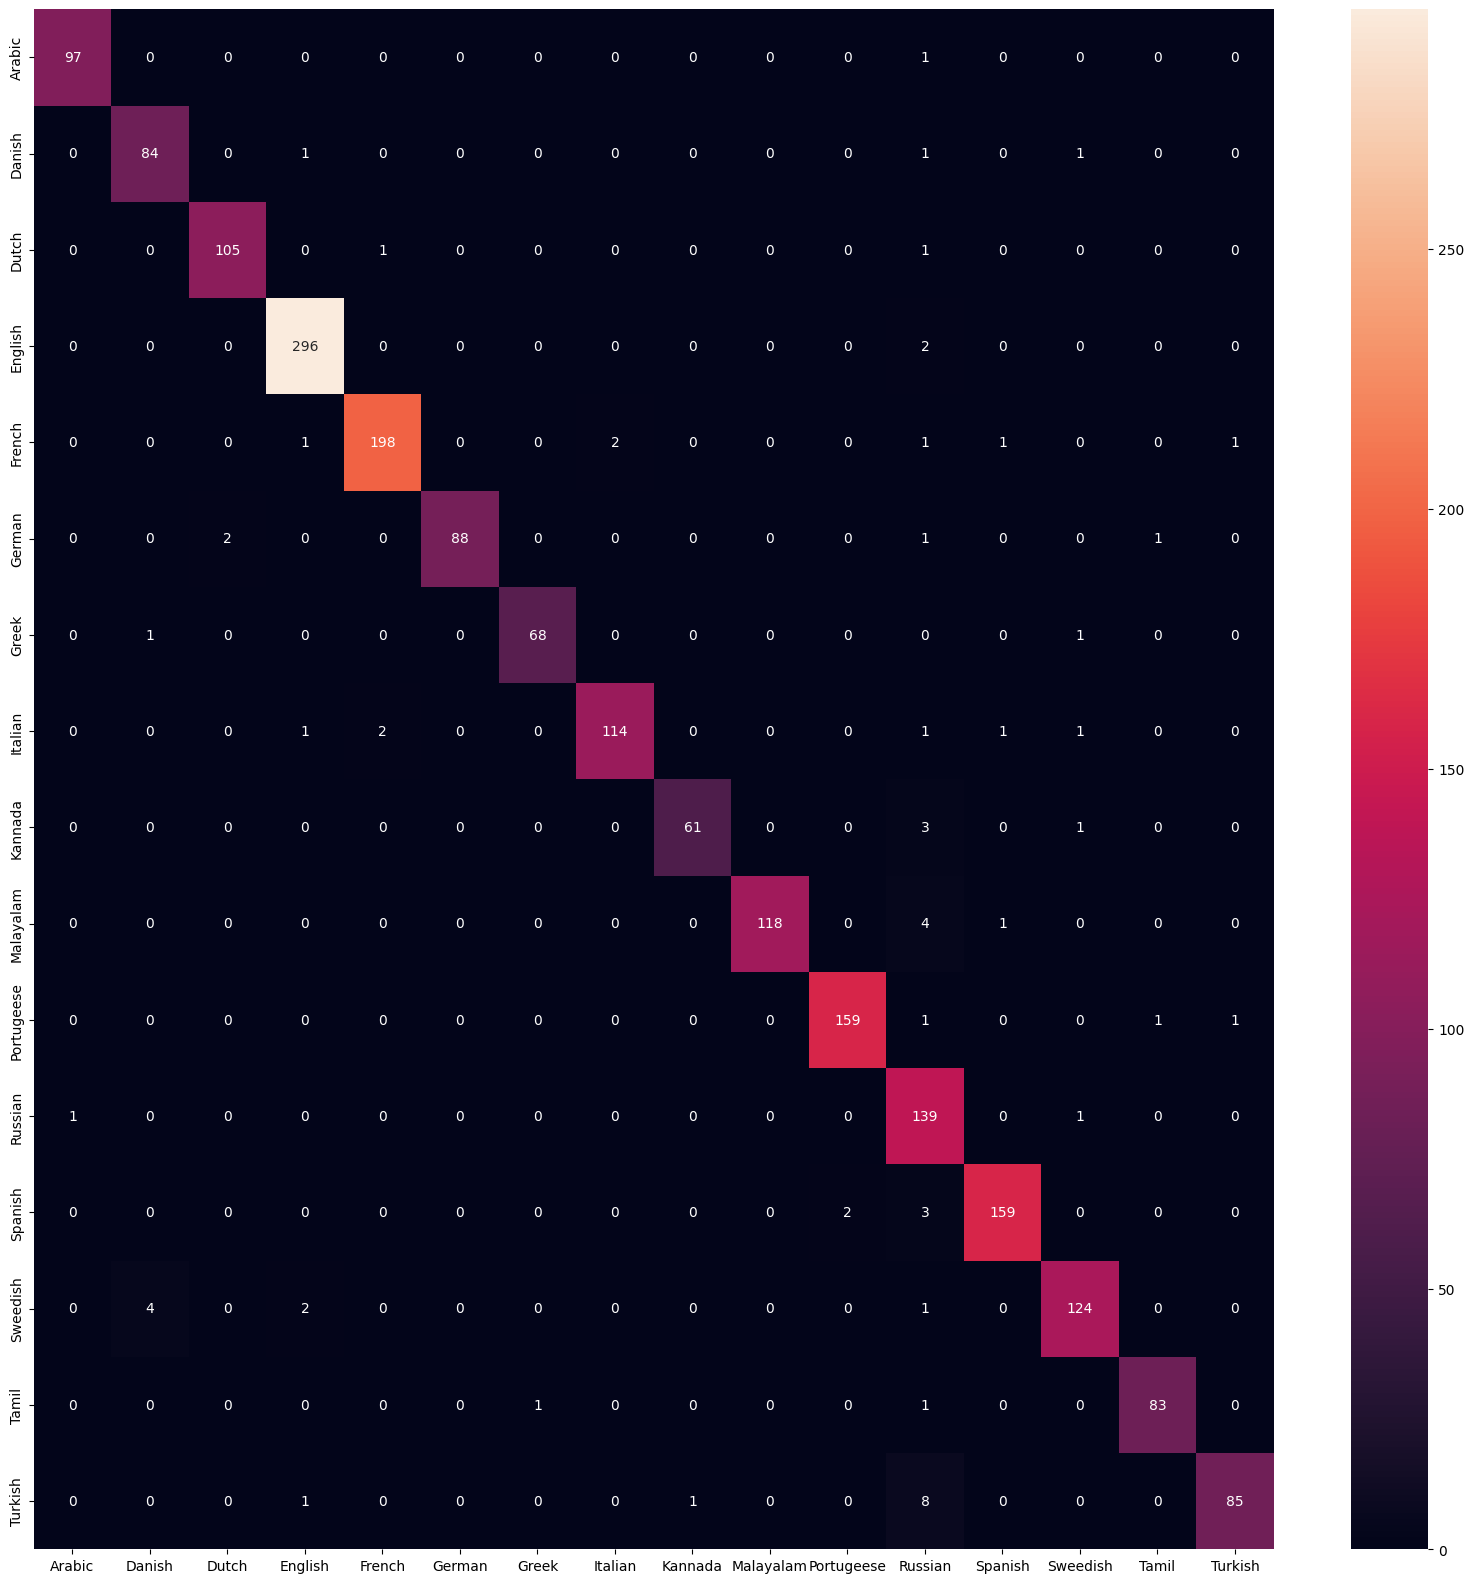

In [11]:
lstm_graph.confusion_matrix(save_fig='lstm_confusion_matrix')

#### GRU model

In [5]:
model = GRU_model

In [7]:
search = GridSearch(model, grid, total_words, max_len)

In [8]:
search.fit(train_padded, train_labels, valid_padded, valid_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 219, 128)          4950912   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 5,157,808
Trainable params: 5,157,808
Non-trainable params: 0
______________________________________________

#####  Save model

In [12]:
best_model = search.get_best()
joblib.dump(best_model, 'Language-Identifier/models/best_gru.pkl')
joblib.dump(best_model.history, 'Language-Identifier/models/gru_history.pkl')

['gru_history.pkl']

##### Load model

In [13]:
model   = joblib.load('/Language-Identifier/models/best_gru.pkl')
history = joblib.load('/Language-Identifier/models/gru_history.pkl')

##### Visualize model

In [14]:
gru_graph = Graphs(model, history)

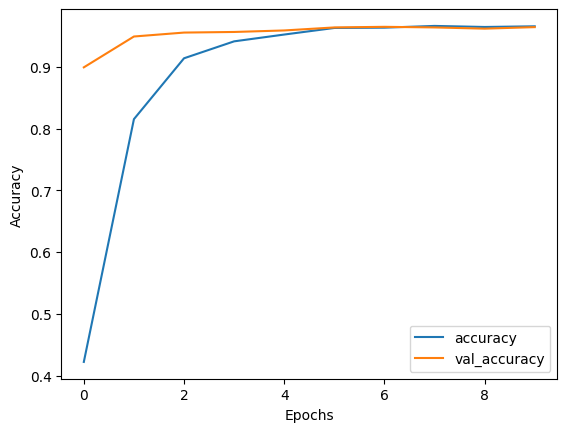

In [17]:
gru_graph.accuracy(save_fig='gru_accuracy')

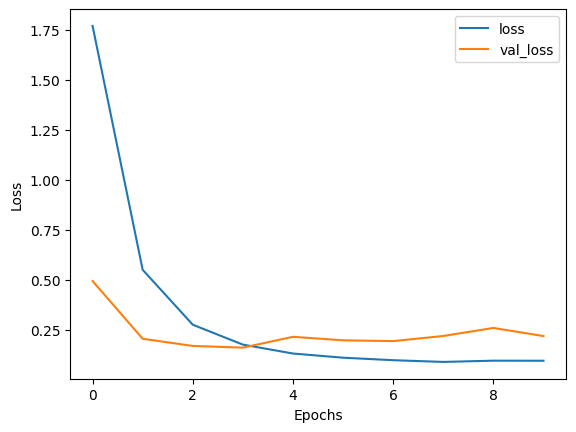

In [18]:
gru_graph.loss(save_fig='gru_loss')

64/64 [==============================] - 9s 131ms/step


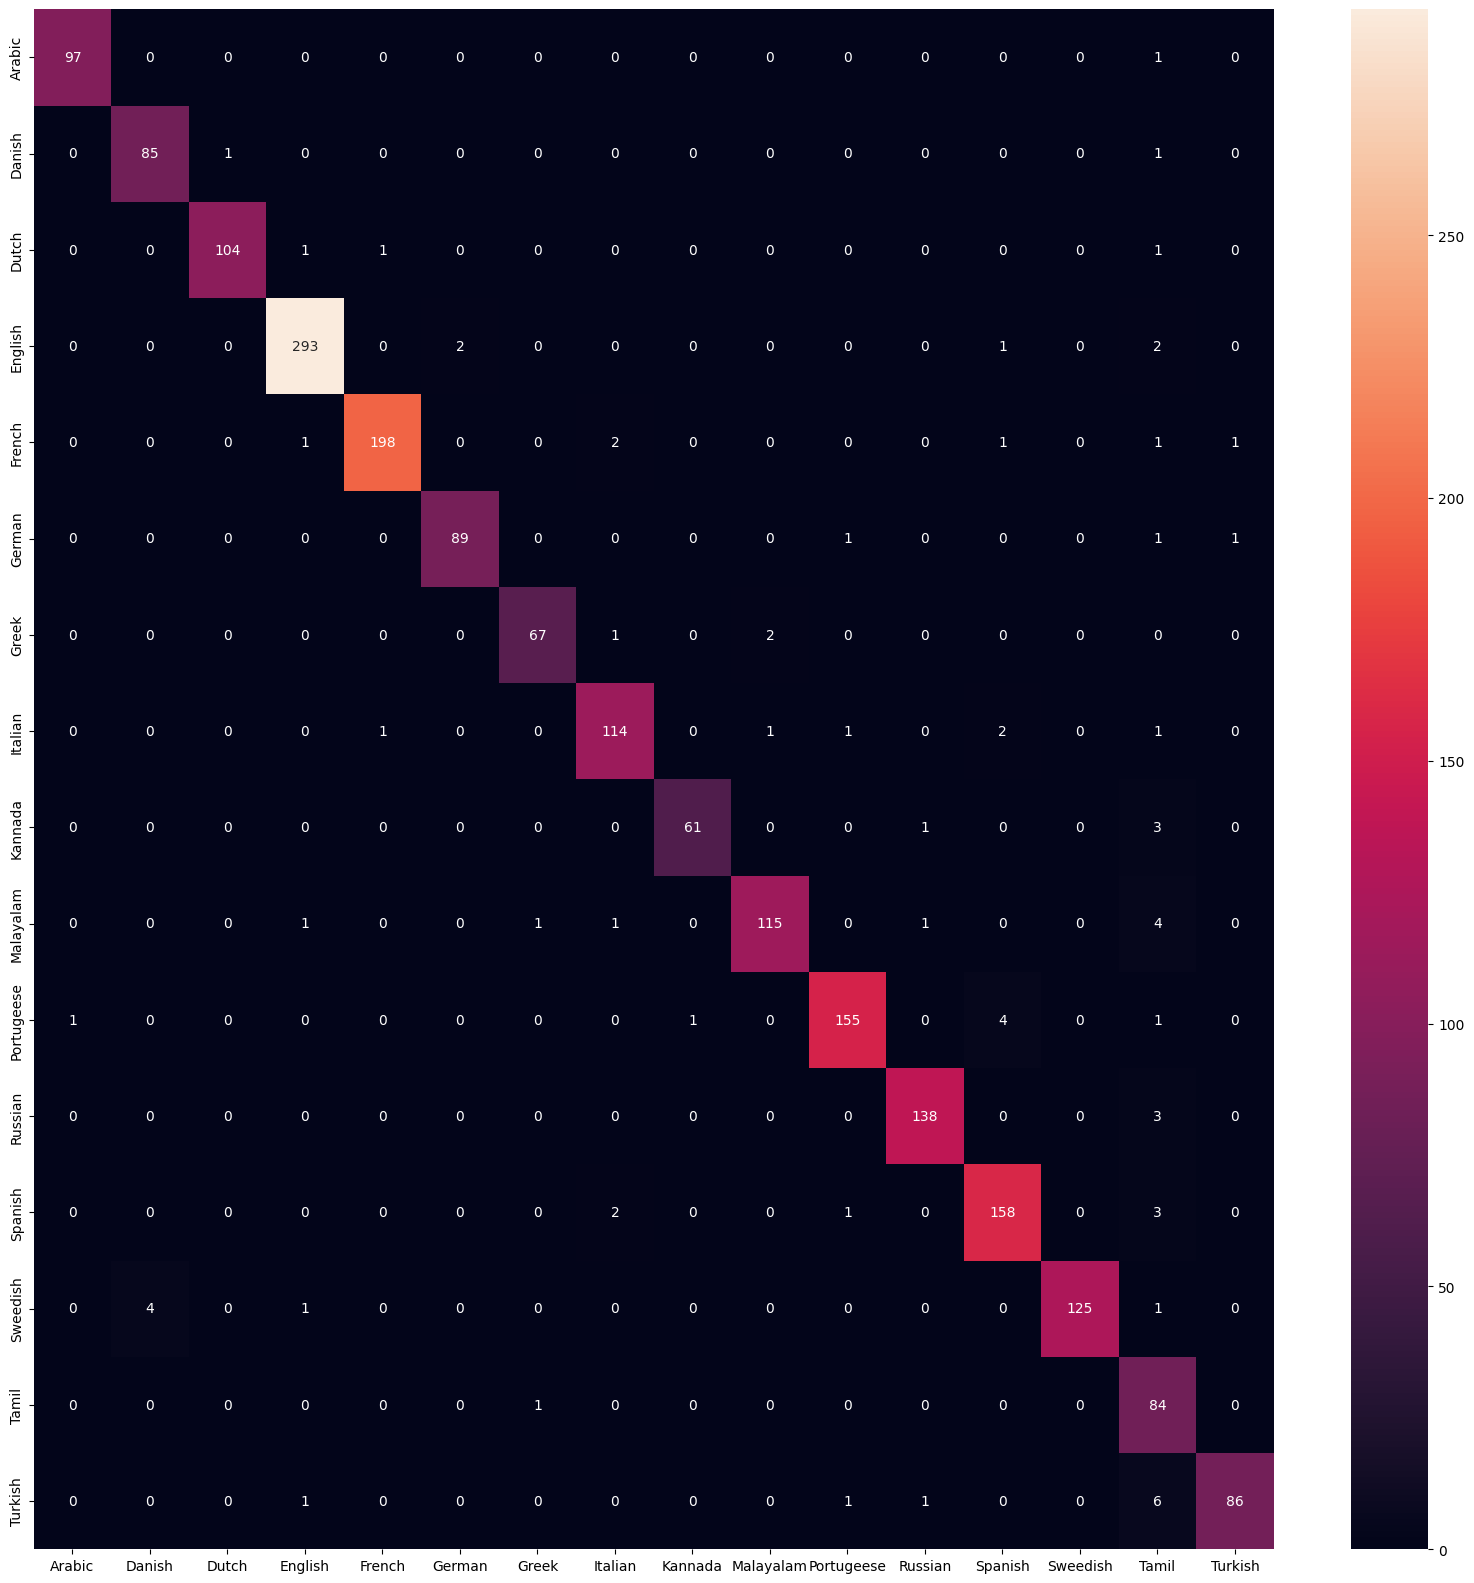

In [19]:
gru_graph.confusion_matrix('gru_confusion_matrix')

#### Conv1D

In [11]:
model = CONV_model

In [12]:
search = GridSearch(model, grid, total_words, max_len)

In [13]:
search.fit(train_padded, train_labels, valid_padded, valid_labels)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 219, 128)          4950912   
                                                                 
 conv1d (Conv1D)             (None, 215, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_54 (Dense)            (None, 32)                4128      
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_55 (Dense)            (None, 16)                528       
                                                     

##### Save model

In [21]:
best_model = search.get_best()
joblib.dump(best_model, '/Language-Identifier/models/best_conv.pkl')
joblib.dump(best_model.history, '/Language-Identifier/models/conv_history.pkl')

['conv_history.pkl']

##### Load model

In [22]:
model   = joblib.load('/home/hossamasaad/Desktop/Workspace/Langauge Identifier/Language-Identifier/models/best_conv.pkl')
history = joblib.load('/home/hossamasaad/Desktop/Workspace/Langauge Identifier/Language-Identifier/models/conv_history.pkl')

##### Visualize the model

In [23]:
conv_graph = Graphs(model, history)

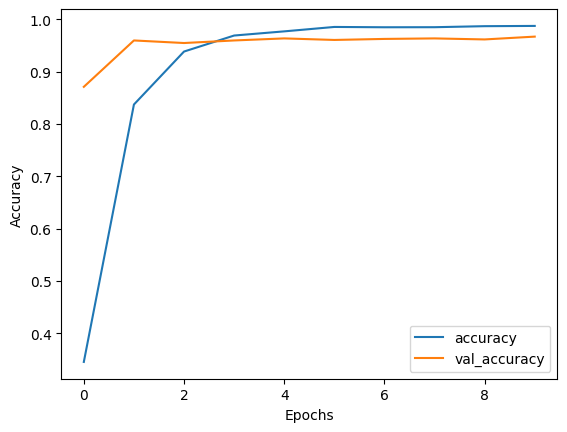

In [26]:
conv_graph.accuracy('conv_accuracy')

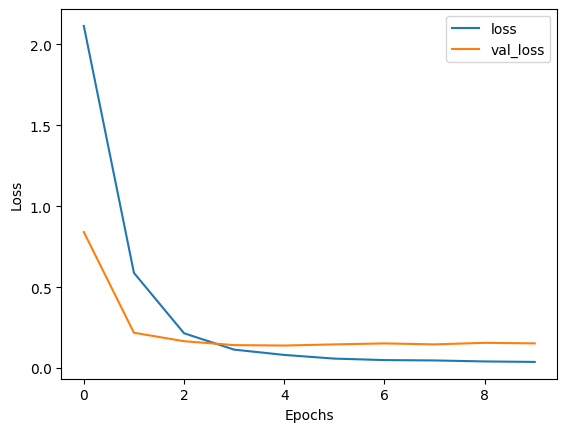

In [27]:
conv_graph.loss('conv_loss')

64/64 [==============================] - 1s 14ms/step


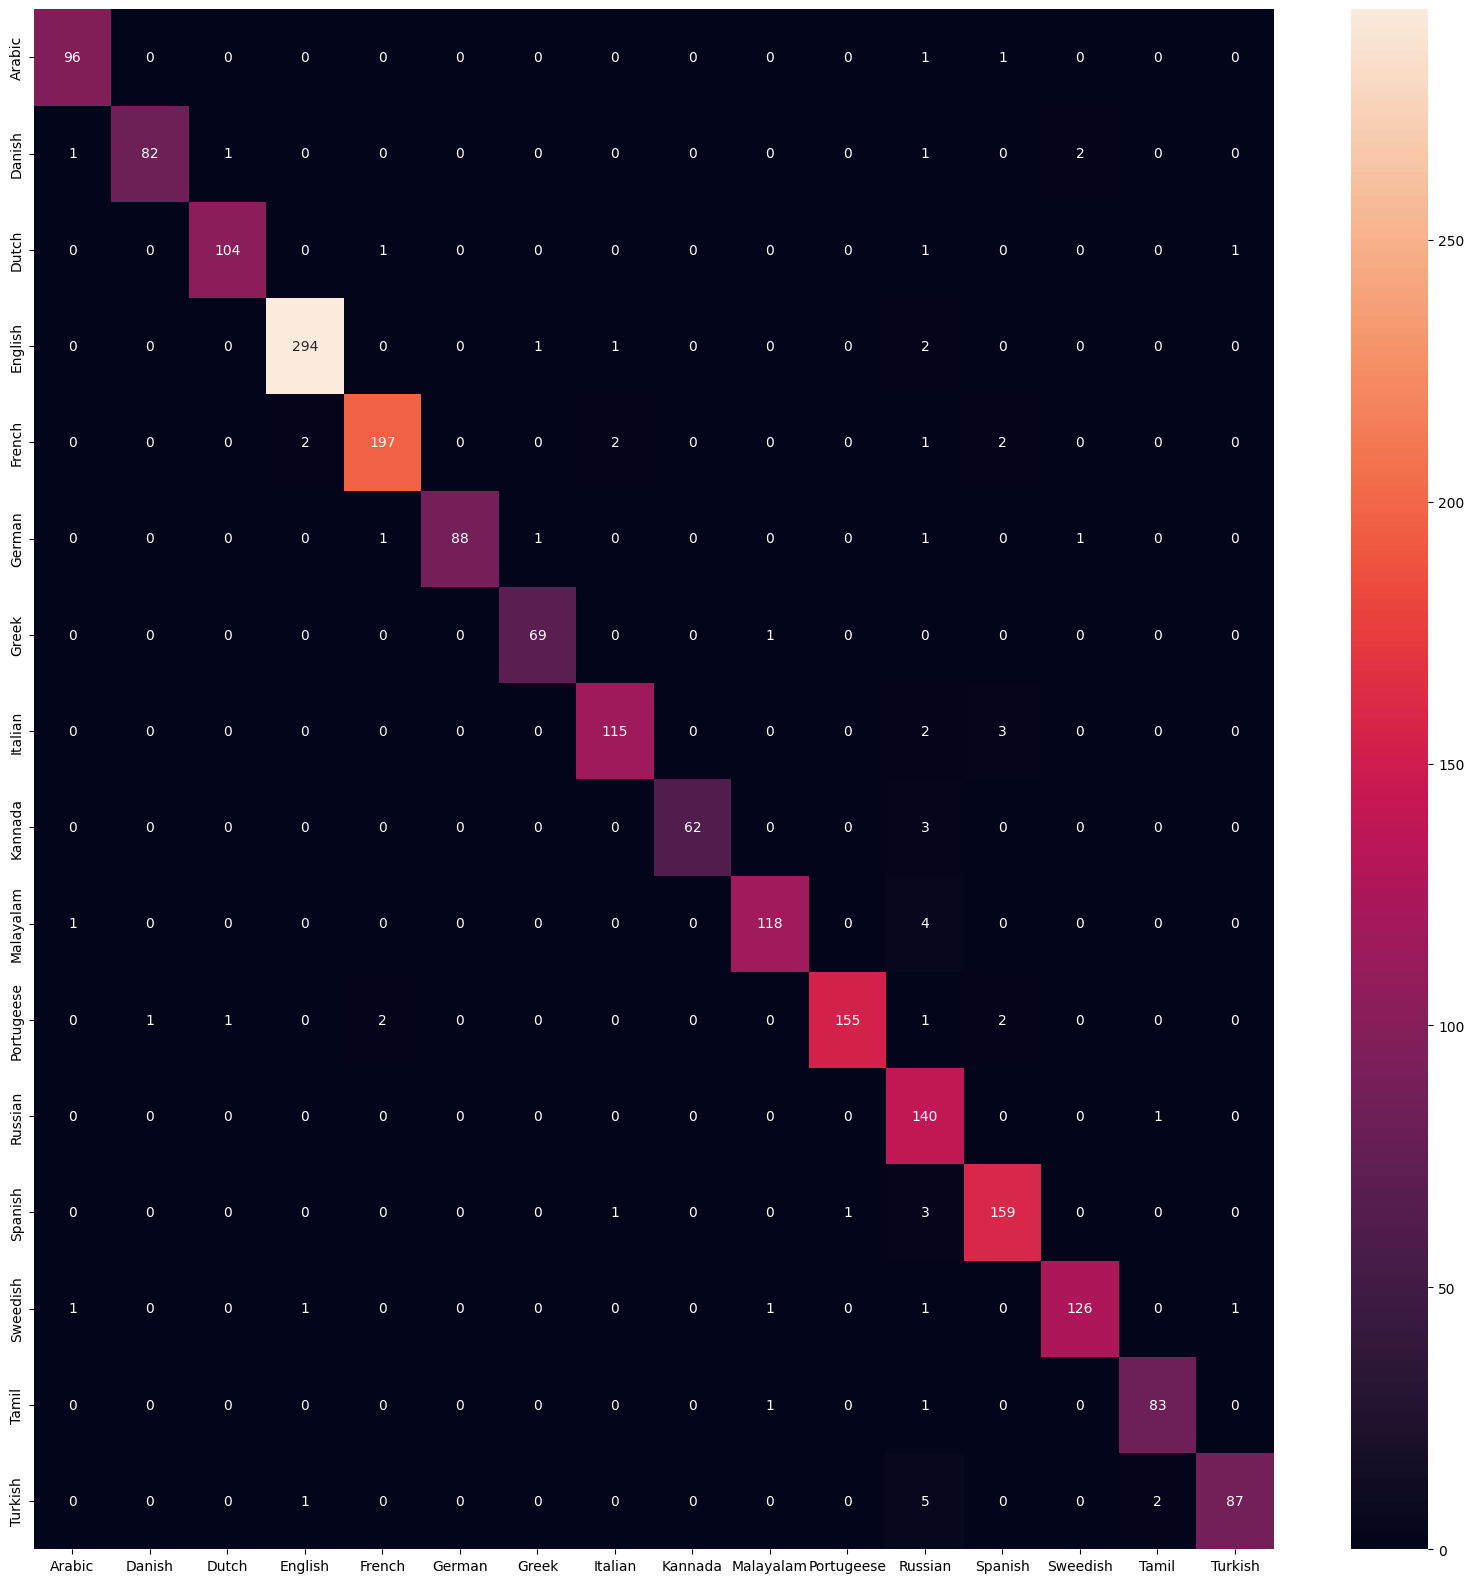

In [28]:
conv_graph.confusion_matrix('conv_confusion_matrix')

### Saving embedding vectors

Vectors to visualize using embedding projector

In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(38679, 128)


In [54]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [55]:
for word_num in range(1, weights.shape[0]):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()